## 1. Importing Dependencies and Initial Setup

In [25]:
import logging, os, joblib, pickle
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve,
    precision_recall_curve, 
    auc,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.inspection import permutation_importance

%matplotlib inline
datapath = Path("../data/default_dataset.csv")
model_dump = Path("../model/model_dump.joblib")
encoder_dump = Path("../model/encoder_dump.pkl")
state_dump = Path("../model/state_dump.pkl")
pd.set_option("display.max_columns", None)
pd.set_option('display.expand_frame_repr', False)
logging.basicConfig(
    level = logging.INFO,       # For verbose logging
    # level = logging.ERROR     # For logging only errors
    format = "%(levelname)s: %(message)s"
)
np.random.seed(42)

try:
    os.makedirs("../model")
except FileExistsError:
    logging.warning("The existing files from previous model will be overwritten")

state_holder = dict()
logging.info("Initial Setup Process Complete")

INFO: Initial Setup Process Complete


## 2. Dataset Fetch

In [26]:
try:
    df = pd.read_csv(datapath)
    df1 = pd.read_csv(datapath)

    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
    df['SeniorCitizen'] = df['SeniorCitizen'].map({1: "Yes", 0: "No"})
    df = df.drop("customerID", axis = 1)

    df1['TotalCharges'] = pd.to_numeric(df1['TotalCharges'], errors='coerce').fillna(0)
    df1['SeniorCitizen'] = df1['SeniorCitizen'].map({1: "Yes", 0: "No"})
    state_holder["dataframe"] = df1
    state_holder["feature_list"] = df1.columns
except FileNotFoundError:
    logging.error("Dataset is not found, please check the dataset path and try again")
    raise
except Exception as e:
    logging.error(f"Failed to load dataset {e}")
finally:
    logging.info(f"Dataset shape received: {df.shape}")
    logging.info("Dataset loading process completed")

INFO: Dataset shape received: (7043, 20)
INFO: Dataset loading process completed


## 3. Dataset Analysis

Showing first 5 rows of the dataset

In [27]:
df.head(n = 5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Showing the dataset columns

In [28]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Showing columns and unique values in each column

In [29]:
categorical_cols = df.select_dtypes(include = "object").columns.to_list()

categorical_info = pd.DataFrame({
    "Column": categorical_cols,
    "Unique_Values": [df[i].unique() for i in categorical_cols],
    "Unique_Count": [df[i].nunique() for i in categorical_cols]
})

categorical_info

,Column,Unique_Values,Unique_Count
0,gender,"[Female, Male]",2
1,SeniorCitizen,"[No, Yes]",2
2,Partner,"[Yes, No]",2
3,Dependents,"[No, Yes]",2
4,PhoneService,"[No, Yes]",2
5,MultipleLines,"[No phone service, No, Yes]",3
6,InternetService,"[DSL, Fiber optic, No]",3
7,OnlineSecurity,"[No, Yes, No internet service]",3
8,OnlineBackup,"[Yes, No, No internet service]",3
9,DeviceProtection,"[No, Yes, No internet service]",3


Distribution of class in target values (churn column)

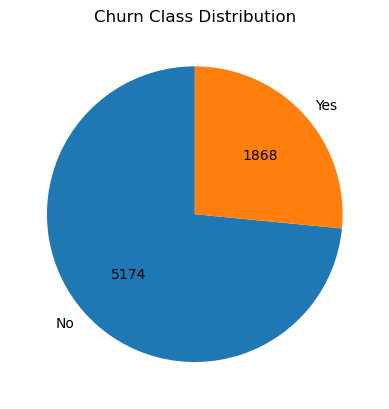

In [30]:
a = df['Churn'].value_counts()
plt.pie(
    a,
    labels=a.index,
    autopct=lambda p: f'{int(p*sum(a)/100)}',
    startangle=90
)
plt.title("Churn Class Distribution")
plt.show()

Insights

1. Customer ID has been removed as it is not a useful feature for training our model
2. Class imbalance identified in the target column

## 4. Exploratory Data Analysis (EDA)

Showing descriptive Statistical Analysis

In [31]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


## 5. Numerical Features Analysis

Histogram plot of Numerical Features

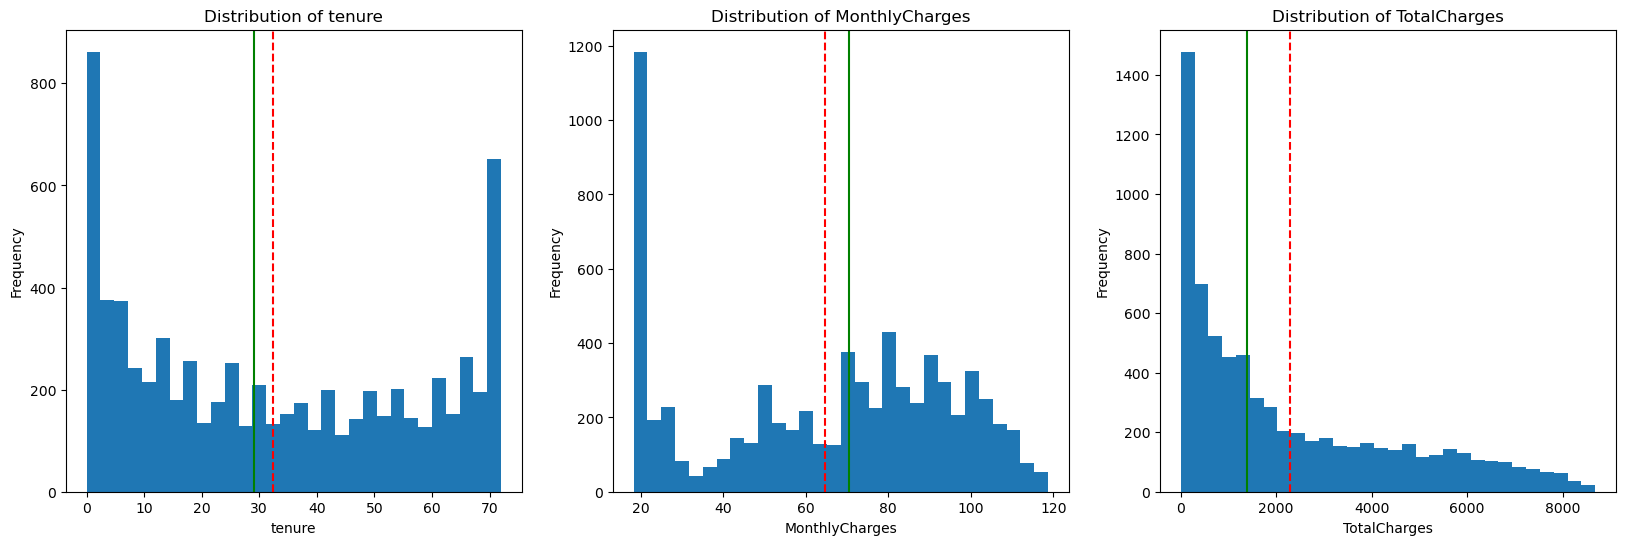

In [32]:
def plot_hist(ax, df: pd.DataFrame, column_name: str):
    ax.hist(df[column_name], bins=30)
    ax.set_title(f"Distribution of {column_name}")
    ax.set_xlabel(column_name)
    ax.set_ylabel("Frequency")
    ax.axvline(df[column_name].mean(), color = "red", linestyle = "--", label = "Mean")
    ax.axvline(df[column_name].median(), color = "green", linestyle = "-", label = "Median")

fig, ax = plt.subplots(1,3, figsize=(20, 6))
plot_hist(ax[0], df, "tenure")
plot_hist(ax[1], df, "MonthlyCharges")
plot_hist(ax[2], df, "TotalCharges")

Boxplot of Numerical Features

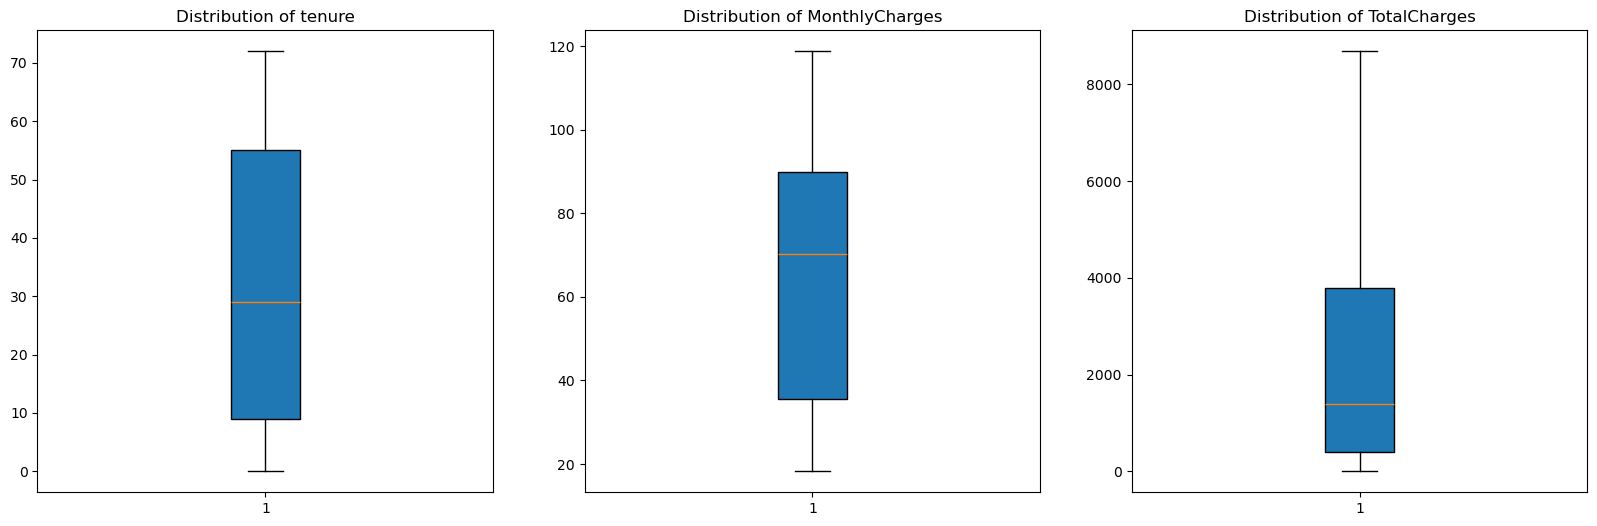

In [33]:
def plot_box(ax, df: pd.DataFrame, column_name: str):
    ax.boxplot(df[column_name], patch_artist=True)
    ax.set_title(f"Distribution of {column_name}")

fig, ax = plt.subplots(1,3, figsize=(20, 6))
plot_box(ax[0], df, "tenure")
plot_box(ax[1], df, "MonthlyCharges")
plot_box(ax[2], df, "TotalCharges")

Correlation features of Numerical Features

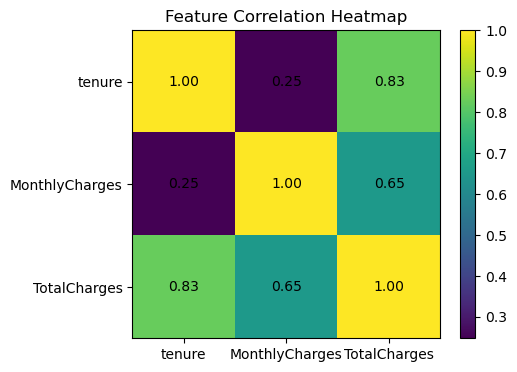

In [34]:
corr = df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()

plt.figure(figsize=(5,4))
im = plt.imshow(corr)
plt.colorbar(im)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(
            j, i,
            f'{corr.iloc[i, j]:.2f}',
            ha='center',
            va='center',
            color='black'
        )
plt.title("Feature Correlation Heatmap")
plt.show()

## 6. Categorical Feature Analysis

In [35]:
categorical_cols = df.select_dtypes(include = "object").columns.to_list()

Countplot for Categorical Columns

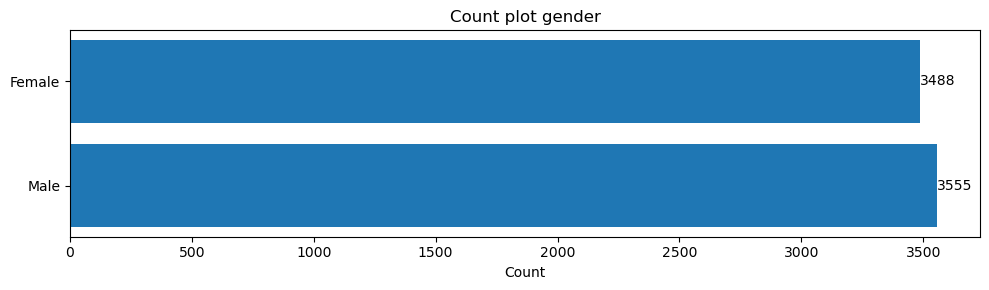

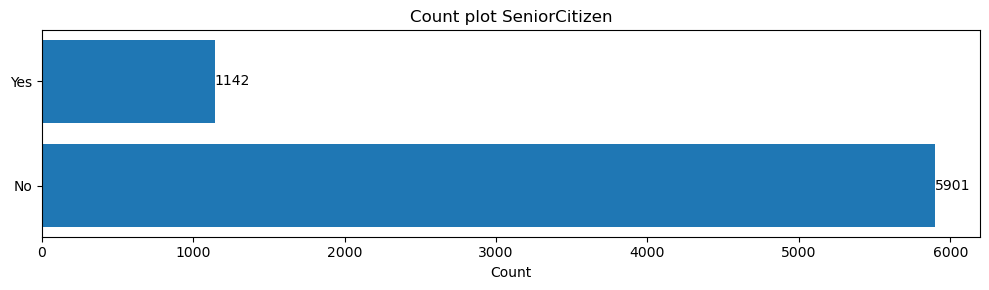

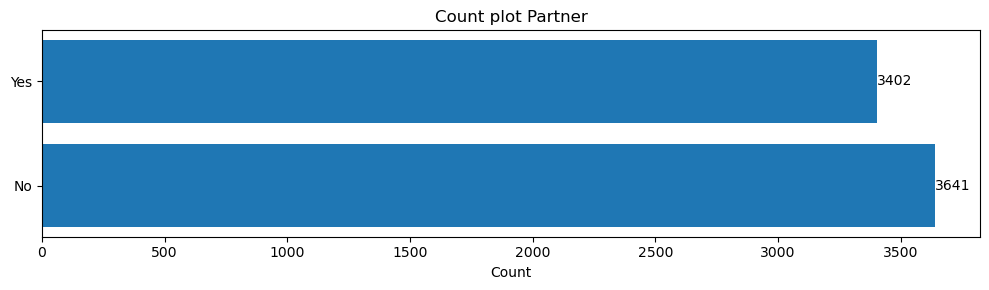

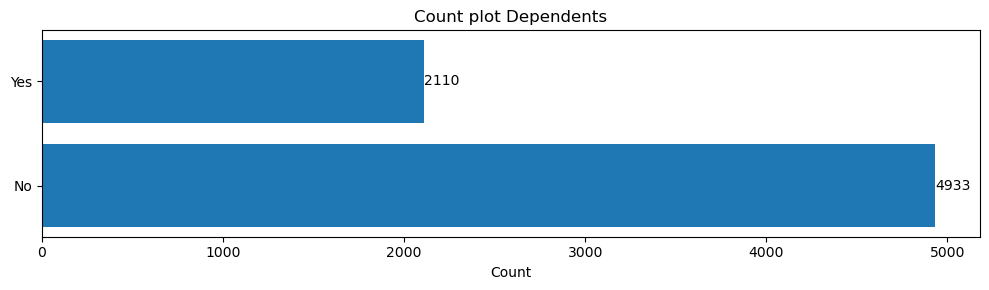

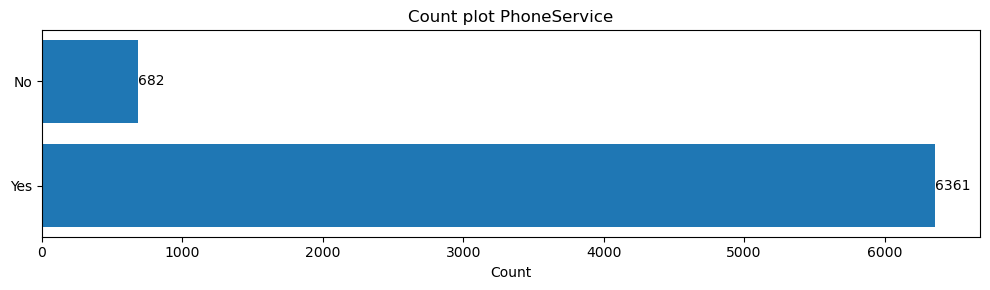

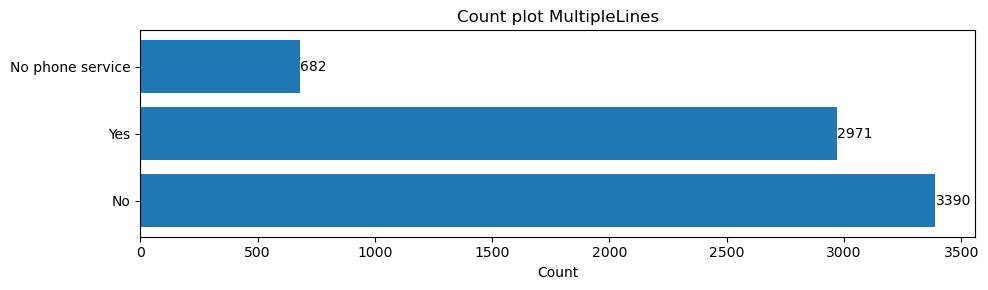

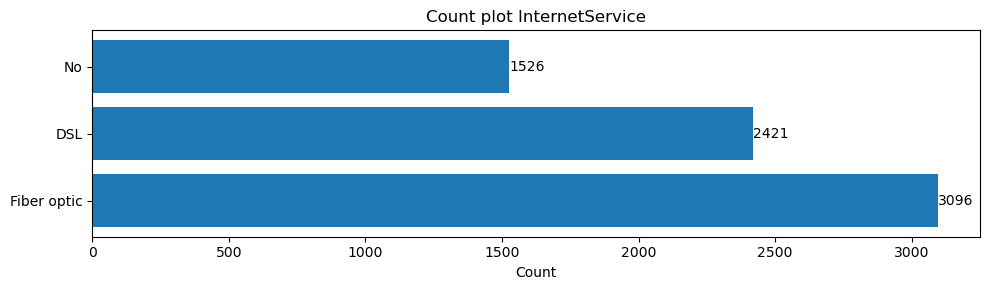

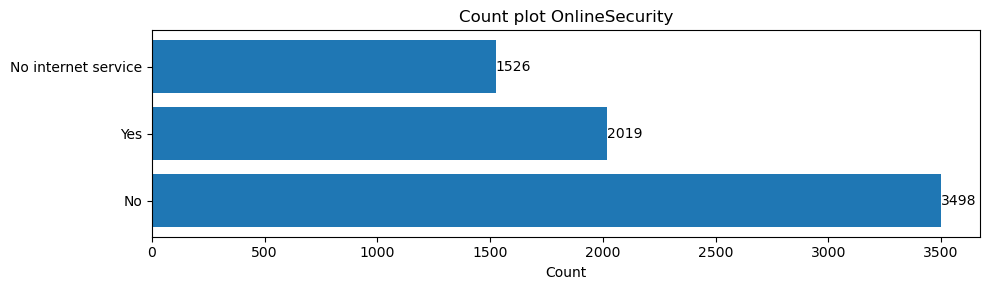

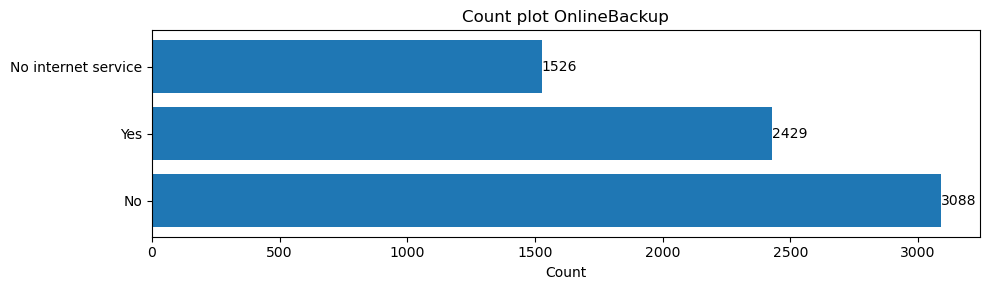

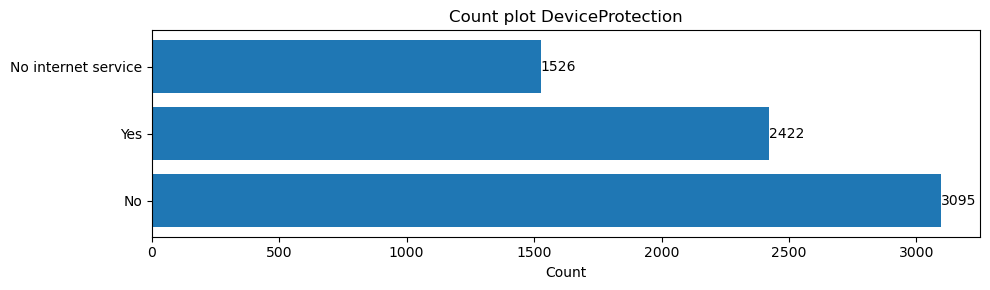

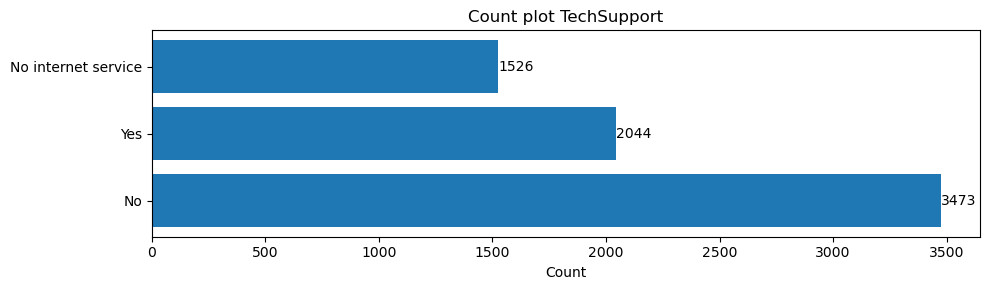

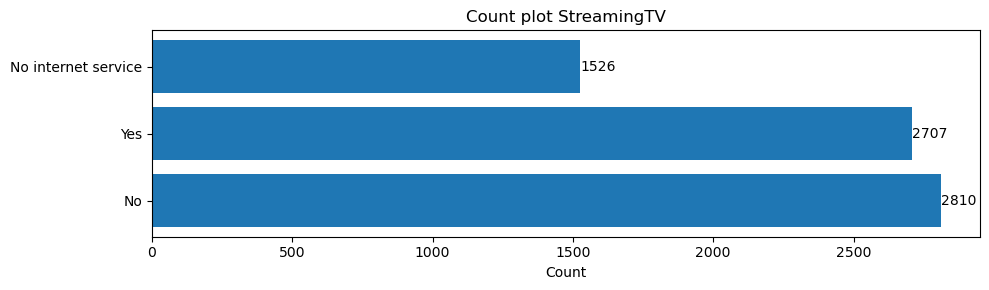

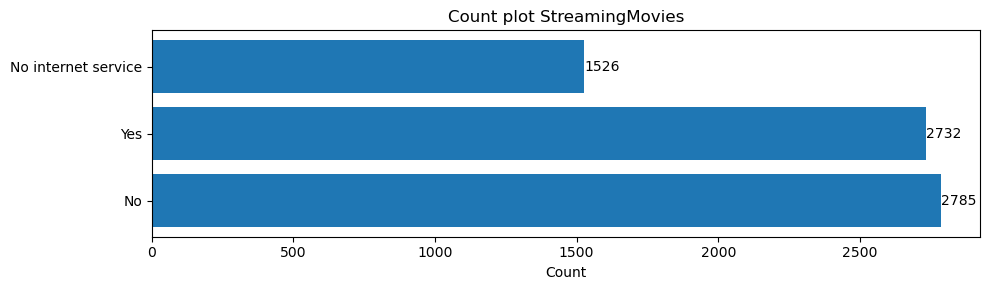

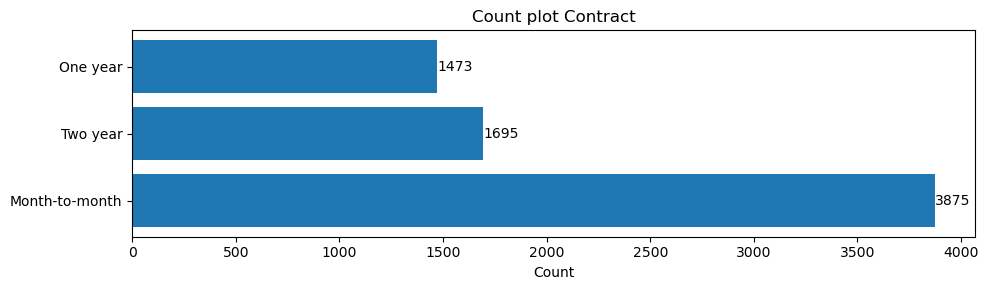

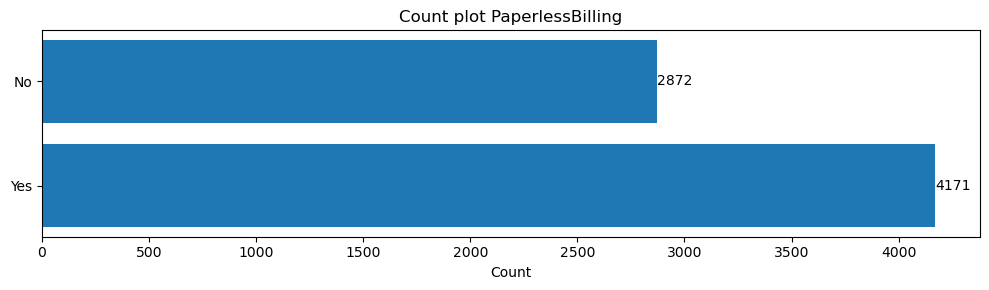

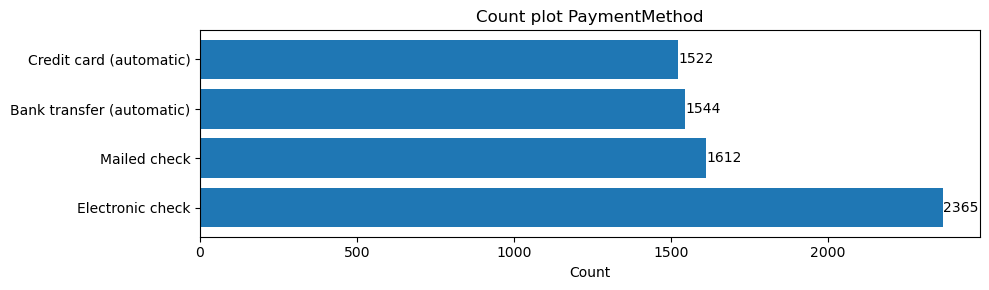

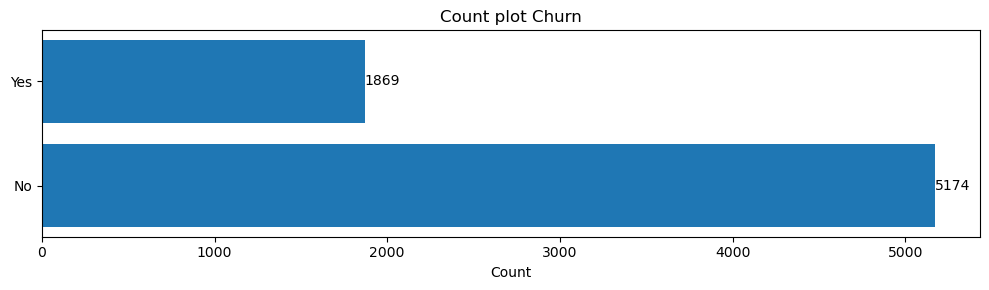

In [36]:
for i in categorical_cols:
    counts = df[i].value_counts()

    plt.figure(figsize=(10, 3))
    bars = plt.barh(counts.index, counts.values)
    plt.title(f"Count plot {i}")
    plt.xlabel("Count")
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width,
            bar.get_y() + bar.get_height() / 2,
            str(width),
            va='center'
        )
    plt.tight_layout()
    plt.show()

## 7. Data Preprocessing

In [37]:
try:
    map_binary = {"No": 0, "Yes": 1}
    df['Churn'] = df['Churn'].map(map_binary)
    object_cols = df.select_dtypes(include = "object").columns
    encoders = {}

    for i in object_cols:
        label_encoder = LabelEncoder()
        df[i] = label_encoder.fit_transform(df[i])
        encoders[i] = label_encoder
        
    with open (encoder_dump, "wb") as f:
        pickle.dump(encoders, f)
    
except Exception as e:
    logging.error(f"Failed to preprocess data: {e}")
finally:
    logging.info("Dataset preprocessing completed")

INFO: Dataset preprocessing completed


Preparing data for training

In [38]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

logging.info("Data splitting and oversampling process completed")

INFO: Data splitting and oversampling process completed


## 8. Training the model

In [ ]:
best_score = -float("inf")
model = None
models_config = {
    "XGBClassifier": {
        "estimator": xgb.XGBClassifier(
            eval_metric = "auc",
            random_state = 42,
            tree_method = "hist",
            n_jobs = -1
        ),
        "params": {
            "n_estimators": [100, 200, 300, 400, 500],
            "max_depth": [3, 4, 5, 6, 7],
            "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
            "subsample": [0.6, 0.7, 0.8, 0.9],
            "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
            "min_child_weight": [1, 3, 5, 7],
            "gamma": [0, 0.1, 0.3, 0.5],
            "reg_alpha": [0.1, 0.5, 1.0],
            "reg_lambda": [0.1, 0.5, 1.0]
        }
    },

    "LogisticRegression": {
        "estimator": Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                max_iter=2000,
                solver="liblinear",
            ))
        ]),
        "params": {
            "clf__C": np.logspace(-3, 2, 20),
            "clf__penalty": ["l1", "l2"]
        }
    },

    "SVC": {
        "estimator": Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("clf", SVC(
                probability=True,
                random_state=42
            ))
        ]),
        "params": {
            "clf__C": np.logspace(-2, 2, 10),
            "clf__kernel": ["linear", "rbf"],
            "clf__gamma": ["scale", "auto"]
        }
    },

    "DecisionTree": {
        "estimator": DecisionTreeClassifier(
            random_state=42
        ),
        "params": {
            "max_depth": [None, 3, 5, 7, 10],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "criterion": ["gini", "entropy"]
        }
    },

    "RandomForest": {
        "estimator": RandomForestClassifier(
            random_state=42,
            n_jobs=-1
        ),
        "params": {
            "n_estimators": [200, 300, 500],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ["sqrt", "log2"]
        }
    }
}

for model_name, config in models_config.items():
    logging.info(f"Training {model_name}")

    search = RandomizedSearchCV(
        estimator = config["estimator"],
        param_distributions = config["params"],
        n_iter = 50 if model_name == "XGBClassifier" else 25,
        scoring = "roc_auc",
        cv = 5,
        random_state = 42,
        n_jobs = -1
    )

    search.fit(X_train_smote, y_train_smote)
    logging.info(f"{model_name} best CV ROC-AUC: {search.best_score_:.4f}")
    if search.best_score_ > best_score:
        model = search.best_estimator_
        best_score = search.best_score_

if hasattr(model, "named_steps"):
    state_holder["model_name"] = model.named_steps["clf"].__class__.__name__
else:
    state_holder["model_name"] = model.__class__.__name__

state_holder["model_parameters"] = model.get_params()
logging.info(f"Selected model: {state_holder["model_name"]} with CV ROC-AUC: {best_score}")

INFO: Training XGBClassifier


INFO: XGBClassifier best CV ROC-AUC: 0.9260
INFO: Training LogisticRegression
INFO: LogisticRegression best CV ROC-AUC: 0.8755
INFO: Training SVC
INFO: SVC best CV ROC-AUC: 0.8995
INFO: Training DecisionTree
INFO: DecisionTree best CV ROC-AUC: 0.8716
INFO: Training RandomForest
INFO: RandomForest best CV ROC-AUC: 0.9247
INFO: Selected model: XGBClassifier with CV ROC-AUC: 0.9259755821764136


Saving the model for later use

In [40]:
joblib.dump(model, model_dump)
logging.info('Model saved successfully')

INFO: Model saved successfully


## 9. Analysis of Model

Classification Report

In [41]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
clf = classification_report(y_test, y_pred, output_dict = True)
clf_report = pd.DataFrame.from_dict(clf)

state_holder["model_classification_report"] = clf_report

print("Classification Report: \n")
clf_report

Classification Report: 



,0,1,accuracy,macro avg,weighted avg
precision,0.862880,0.600515,0.790632,0.731697,0.793425
recall,0.850386,0.624665,0.790632,0.737525,0.790632
f1-score,0.856587,0.612352,0.790632,0.734470,0.791932
support,1036.000000,373.000000,0.790632,1409.000000,1409.000000


Confusion Matrix

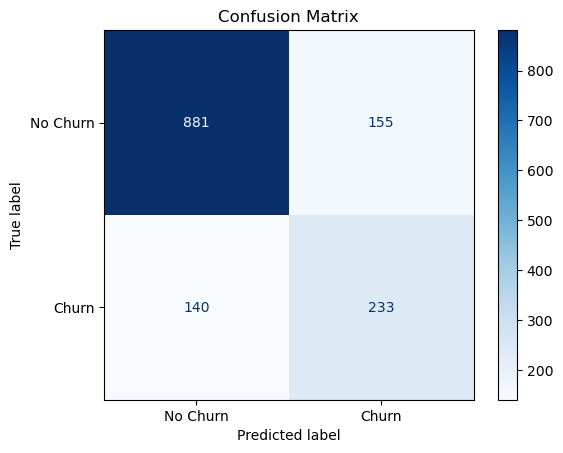

In [42]:
cm = confusion_matrix(y_test, y_pred)

state_holder["model_confusion_matrix"] = cm

disp = ConfusionMatrixDisplay(cm, display_labels = ['No Churn', 'Churn'])
disp.plot(cmap = 'Blues')
plt.title("Confusion Matrix")
plt.show()

ROC-AUC Curve

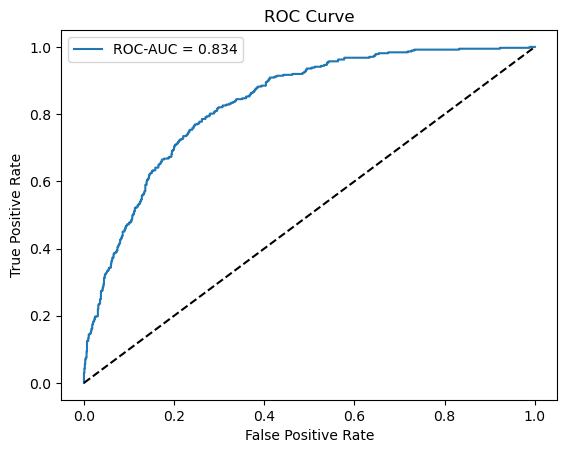

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

state_holder["model_fpr_tpr_auc"] = (fpr, tpr, roc_auc)

plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Precision Recall Curve

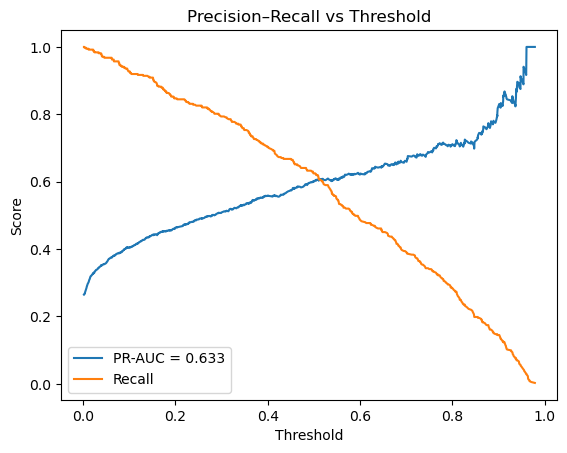

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

state_holder["model_precision_recall_prauc"] = (precision, recall, thresholds, pr_auc)

plt.plot(thresholds, precision[:-1], label = f"PR-AUC = {pr_auc:.3f}")
plt.plot(thresholds, recall[:-1], label = 'Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision–Recall vs Threshold')
plt.show()

Feature Importance Plot

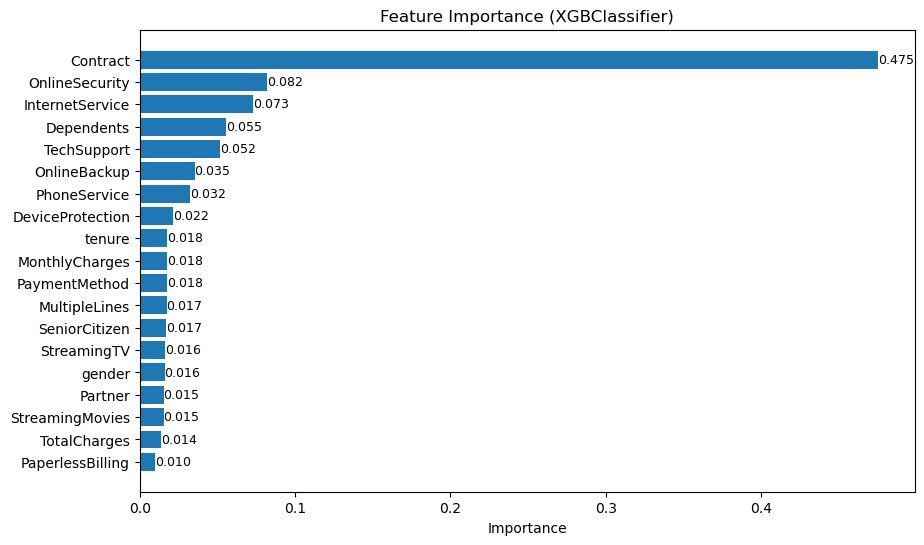

In [45]:
def get_feature_importance(
    model,
    X,
    y=None,
    feature_names=None,
    method="auto",
    n_repeats=10,
    random_state=42
):
    if feature_names is None:
        feature_names = X.columns

    if hasattr(model, "named_steps"):
        clf = model.named_steps["clf"]
    else:
        clf = model

    if method == "auto" and hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_

    elif method == "auto" and hasattr(clf, "coef_"):
        importances = np.abs(clf.coef_).ravel()

    else:
        if y is None:
            raise ValueError("y must be provided for permutation importance")

        result = permutation_importance(
            model,
            X,
            y,
            n_repeats=n_repeats,
            scoring="roc_auc",
            random_state=random_state,
            n_jobs=-1
        )
        importances = result.importances_mean

    fi_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    return fi_df

def plot_feature_importance(feature_df, top_n=20, title="Feature Importance", value_fmt="{:.3f}"):
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_df = feature_df.head(top_n).iloc[::-1]

    ax.set_title(title)
    ax.set_xlabel("Importance")
    ax.set_ylabel("")
    bars = ax.barh(
        plot_df["Feature"],
        plot_df["Importance"]
    )

    for bar in bars:
        width = bar.get_width()
        ax.text(
            width,
            bar.get_y() + bar.get_height() / 2,
            value_fmt.format(width),
            va="center",
            ha="left",
            fontsize=9
        )
        
    return fig

feature_df = get_feature_importance(
    model = model,
    X = X_test,
    y = y_test,
    feature_names = X_test.columns
)

state_holder["feature_importance_dataframe"] = feature_df

fig = plot_feature_importance(
    feature_df,
    title=f"Feature Importance ({state_holder["model_name"]})"
)

state_holder["model_feature_importance"] = fig
plt.show()

Cross Validation Score

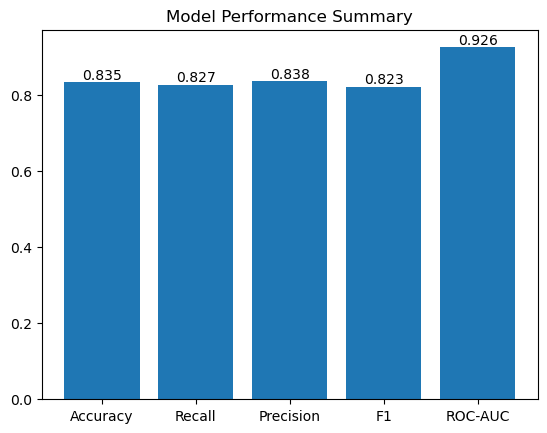

In [46]:
cv_scores = {
    "Accuracy" : cross_val_score(model, X_train_smote, y_train_smote, cv = 5, scoring = "accuracy").mean(),
    "Recall" : cross_val_score(model, X_train_smote, y_train_smote, cv = 5, scoring = "recall").mean(),
    "Precision" : cross_val_score(model, X_train_smote, y_train_smote, cv = 5, scoring = "precision").mean(),
    "F1" : cross_val_score(model, X_train_smote, y_train_smote, cv = 5, scoring = "f1").mean(),
    "ROC-AUC" : cross_val_score(model, X_train_smote, y_train_smote, cv = 5, scoring = "roc_auc").mean()
}

state_holder["model_cv_scores"] = cv_scores

bars = plt.bar(cv_scores.keys(), cv_scores.values())
plt.title('Model Performance Summary')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom'
    )
plt.show()

Model Performance Summary

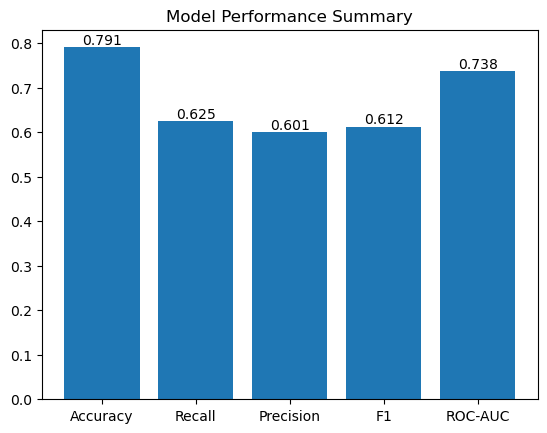

In [47]:
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred)
}

state_holder["model_metrics"] = metrics

bars = plt.bar(metrics.keys(), metrics.values())
plt.title('Model Performance Summary')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom'
    )
plt.show()

In [48]:
with open(state_dump, "wb") as f:
    pickle.dump(state_holder, f)
logging.info("State Backup generation complete")

C:\Users\kaush\AppData\Local\Temp\ipykernel_13300\3568314427.py:2: DeprecationWarning: Pickle, copy, and deepcopy support will be removed from itertools in Python 3.14.
  pickle.dump(state_holder, f)
INFO: State Backup generation complete
